In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pydicom
from random import shuffle, seed
import copy
import cv2
import timm
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim import Adam
from torch.nn import BCELoss
from tqdm.notebook import tqdm
from torchinfo import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
torch.manual_seed(42)
seed(42)

In [4]:
train_folder = 'train_images'
test_folder = 'test_images'

In [5]:
train_metadata = 'train.csv'
test_metadata = 'test.csv'

In [6]:
train_df = pd.read_csv(train_metadata)
test_df = pd.read_csv(test_metadata)

In [7]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [8]:
train_folders = os.listdir(train_folder)

In [9]:
train_folders[:5]

['33624', '64153', '65117', '19605', '40910']

In [10]:
train_df[train_df.patient_id==33624]

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
22215,1,33624,1111416410,L,MLO,56.0,0,0,0,NaN,0,B,49,False
22216,1,33624,1462078398,L,CC,56.0,0,0,0,NaN,0,B,49,False
22217,1,33624,788897862,R,CC,56.0,0,1,0,0.0,0,B,49,True
22218,1,33624,1362210397,R,MLO,56.0,0,1,0,0.0,0,B,49,True


In [11]:
len(train_df['image_id'].value_counts()) == len(train_df)

True

Each image_id is unique so they can be used for assigning the scans to each fold

# Getting the CV-Setup done

The Training data will be split into 5 folds where each fold should contain roughtly the same number of cancer cases

For each patient the left and right breast can probably be placed in a different fold without causing any data leakage

The patient_id equals the folder in train_images and the image_id equals the scan inside the folder

In [12]:
# this function returns the image_ids for five folds with balanced cancer to non-cancer cases

def get_folds_with_image_ids(DF):
    
    df = DF.copy()
    
    patient_ids = list(train_df['patient_id'].unique())  # all unique patient_ids
    shuffle(patient_ids)
    
    # foldes to hold the image ids
    cancer_fold_1, cancer_fold_2, cancer_fold_3, cancer_fold_4, cancer_fold_5 = [], [], [], [], []
    no_cancer_fold_1, no_cancer_fold_2, no_cancer_fold_3, no_cancer_fold_4, no_cancer_fold_5 = [], [], [], [], []
    
    # list of folders
    cancer_folders = [cancer_fold_1, cancer_fold_2, cancer_fold_3, cancer_fold_4, cancer_fold_5]
    no_cancer_folders = [no_cancer_fold_1, no_cancer_fold_2, no_cancer_fold_3, no_cancer_fold_4, no_cancer_fold_5]
    
    # loop over all patient ids and assign them to a fold (each patient + side must be in a single fold)
    for ID in tqdm(patient_ids):
        for side in ['L', 'R']:
            filt = (df['patient_id'] == ID) & (df['laterality'] == side)  # boolean df as filter
            
            # df only with the current patient id & one breast
            current_df = df[filt]
            
            # image ids which should be assigned to one fold
            values_to_assign = current_df['image_id'].values
            
            # array of cancer values from the selected df
            cancer_value = current_df['cancer'].unique()
            
            # should only contain one value!
            if len(cancer_value) > 1:
                print('\n\n\nERROR: GOT DIFFERENT CANCER VALUES!\n\n\n')
            else:
                cancer_value = cancer_value[0]
            
            # the image ids should be assigned to the folder with the least values
            
            if cancer_value == 0:  # add it to one of no cancer folders...
                len_folders = [len(folder) for folder in no_cancer_folders]
                folder = np.array(len_folders).argmin()  # ...to the one with the least values in it
                for image_id in values_to_assign:
                    no_cancer_folders[folder].append(image_id)
                    
            # same with cancer_values
            elif cancer_value == 1:
                len_folders = [len(folder) for folder in cancer_folders]
                folder = np.array(len_folders).argmin()  # the one with the least values
                for image_id in values_to_assign:
                    cancer_folders[folder].append(image_id)
            
    # check if the folders are balanced
    len_cancer_folders = [len(folder) for folder in cancer_folders]
    len_no_cancer_folders = [len(folder) for folder in no_cancer_folders]
    print(f'Length of cancer folders: {len_cancer_folders}')
    print(f'Length of non cancer folders: {len_no_cancer_folders}\n')

    # check if the values got assigned correct
    counted_cancer_cases = sum([len(folder) for folder in cancer_folders])
    number_cancer_cases = len(df[df['cancer'] == 1])
    print(f'Number of cancer cases in total: {number_cancer_cases}')
    print(f'Number of cancer cases in cancer folders: {counted_cancer_cases}\n')

    counted_no_cancer_cases = sum([len(folder) for folder in no_cancer_folders])
    number_no_cancer_cases = len(df[df['cancer'] == 0])
    print(f'Number of non cancer cases in total: {number_no_cancer_cases}')
    print(f'Number of non cancer cases in non cancer folders: {counted_no_cancer_cases}\n')

    # add them up to five folds & shuffle them again
    fold_1, fold_2, fold_3, fold_4, fold_5 = [cancer + no_cancer for cancer, no_cancer in
                                              zip(cancer_folders, no_cancer_folders)]
    [shuffle(fold) for fold in [fold_1, fold_2, fold_3, fold_4, fold_5]]

    # print final length
    print(f'Final Length of Folds: {[len(fold) for fold in [fold_1, fold_2, fold_3, fold_4, fold_5]]}')
            
    return fold_1, fold_2, fold_3, fold_4, fold_5

In [13]:
%%time
fold_1, fold_2, fold_3, fold_4, fold_5 = get_folds_with_image_ids(train_df)

  0%|          | 0/11913 [00:00<?, ?it/s]

Length of cancer folders: [234, 232, 230, 232, 230]
Length of non cancer folders: [10711, 10709, 10709, 10710, 10709]

Number of cancer cases in total: 1158
Number of cancer cases in cancer folders: 1158

Number of non cancer cases in total: 53548
Number of non cancer cases in non cancer folders: 53548

Final Length of Folds: [10945, 10941, 10939, 10942, 10939]
CPU times: user 51.9 s, sys: 79.5 ms, total: 52 s
Wall time: 51.9 s


# Create the Datasets

The Datasets take as input the image_ids & the df and returns the preprocessed image and the target

Data Augmentation will be implementated in another notebook

In [14]:
class Data(Dataset):
    
    # later gets initialized with one or four folds (cross-validation)
    def __init__(self, fold_image_ids, DF):
        self.df = DF.copy()
        
        self.image_ids = copy.deepcopy(fold_image_ids)  # dont shuffle original
        shuffle(self.image_ids)  # shuffle new image ids
        
        self.df_filtered = self.df[self.df['image_id'].isin(self.image_ids)]  # needs the same length for below
        
        # Problem: The new dataframe should be sorted with the new image_ids to get the correct other values
        self.df_sorted = self.df_filtered.iloc[np.argsort([self.image_ids.index(i) for i in 
                                                           self.df_filtered['image_id']])]
        
        # get the cancer value for each image id
        self.targets = list(self.df_sorted['cancer'].values)
        
        # also get the corresponding patient_ids for correct assignment below
        self.patient_ids = list(self.df_sorted['patient_id'].values)
                                              
        self.n_samples = len(self.image_ids)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        
        # get the full path to the image_id of index...
        folder = train_folder
        patient_id = str(self.patient_ids[index])
        image_id = str(self.image_ids[index]) + '.dcm'  # each image_id is a .dcm file
        path_img = os.path.join(folder, patient_id, image_id)  # path to each image id
        
        img = pydicom.dcmread(path_img).pixel_array  # img as np.array
        
        # normalize it (values might be greater then 255 or less then 0)
        img = (img - img.min()) / (img.max() - img.min())
        
        img = cv2.resize(img, (512, 512))  # try 512 resolution first
        
        img_tensor = torch.tensor(img).type(torch.float32)
        
        img_tensor = torch.unsqueeze(img_tensor, 0)  # add rgb dim in shape index 0
        
        # to feed the grayscaled tensor into a pretrained rgb-model repeat the tensor 3 times in dim 0
        X = img_tensor.repeat(3, 1, 1)
        
        y = torch.tensor(self.targets[index]).type(torch.float32)
        
        return X, y

The data is highly unbalanced: 2 ways to fix this problem <br>
1) Assign cancer cases a higher loss <br>
2) Feed them more often (used approach)


In [15]:
def get_class_weights(DF):
    df = DF.copy()
    
    num_cancer_cases = len(df[df['cancer'] == 1])
    num_no_cancer_cases = len(df[df['cancer'] == 0])
    
    # the class weights just need to have a correct relative size
    # class weight for no cancer cases is set as 1 -> cancer cases weight is the number they appear less
    no_cancer_weight = 1
    cancer_weight = round(num_no_cancer_cases / num_cancer_cases, 2)
    
    print(f'Weights: No Cancer: {no_cancer_weight}; Cancer: {cancer_weight}')
    
    return [no_cancer_weight, cancer_weight]

In [16]:
class_weights = get_class_weights(train_df)

Weights: No Cancer: 1; Cancer: 46.24


The weighted random sampler needs to be created later, when the folds are made (it assigns each point a value)

# Create a first model using timm & transfer learning

In [17]:
model = timm.create_model('tf_efficientnetv2_xl_in21k', pretrained=True)

In [18]:
summary(model, input_data=torch.randn((1, 3, 512, 512)))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [1, 21843]                --
├─Conv2dSame: 1-1                             [1, 32, 256, 256]         864
├─BatchNormAct2d: 1-2                         [1, 32, 256, 256]         64
│    └─Identity: 2-1                          [1, 32, 256, 256]         --
│    └─SiLU: 2-2                              [1, 32, 256, 256]         --
├─Sequential: 1-3                             [1, 640, 16, 16]          --
│    └─Sequential: 2-3                        [1, 32, 256, 256]         --
│    │    └─ConvBnAct: 3-1                    [1, 32, 256, 256]         9,280
│    │    └─ConvBnAct: 3-2                    [1, 32, 256, 256]         9,280
│    │    └─ConvBnAct: 3-3                    [1, 32, 256, 256]         9,280
│    │    └─ConvBnAct: 3-4                    [1, 32, 256, 256]         9,280
│    └─Sequential: 2-4                        [1, 64, 128, 128]         --
│    │ 

In [19]:
# make pretrained model weights untrainable
for param in model.parameters():
    param.requires_grad = False

In [20]:
# replace Linear part of the model with a fitting output
class Linear_Replacement(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.fc_1 = nn.Linear(1280, 128)
        self.bn_1 = nn.BatchNorm1d(128)
        self.act_1 = nn.ReLU()
        self.drop_1 = nn.Dropout(0.2)
        
        self.fc_2 = nn.Linear(128, 32)
        self.bn_2 = nn.BatchNorm1d(32)
        self.act_2 = nn.ReLU()
        self.drop_2 = nn.Dropout(0.2)
        
        self.fc_3 = nn.Linear(32, 1)
        self.out = nn.Sigmoid()
        
    def forward(self, x):

        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.act_1(x)
        x = self.drop_1(x)
        
        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.act_2(x)
        x = self.drop_2(x)
        
        x = self.fc_3(x)
        x = self.out(x)
        
        return x

In [21]:
model_lin_replacement = Linear_Replacement()

In [22]:
model.classifier = model_lin_replacement

In [23]:
summary(model, input_data=torch.randn((1, 3, 512, 512)))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [1, 1]                    --
├─Conv2dSame: 1-1                             [1, 32, 256, 256]         (864)
├─BatchNormAct2d: 1-2                         [1, 32, 256, 256]         64
│    └─Identity: 2-1                          [1, 32, 256, 256]         --
│    └─SiLU: 2-2                              [1, 32, 256, 256]         --
├─Sequential: 1-3                             [1, 640, 16, 16]          --
│    └─Sequential: 2-3                        [1, 32, 256, 256]         --
│    │    └─ConvBnAct: 3-1                    [1, 32, 256, 256]         (9,280)
│    │    └─ConvBnAct: 3-2                    [1, 32, 256, 256]         (9,280)
│    │    └─ConvBnAct: 3-3                    [1, 32, 256, 256]         (9,280)
│    │    └─ConvBnAct: 3-4                    [1, 32, 256, 256]         (9,280)
│    └─Sequential: 2-4                        [1, 64, 128, 128]         

In [24]:
model.to(device)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (2): ConvBnAct(
        

## Define optimizer, loss function & scheduler

In [25]:
# binary-crossentroy-loss
loss_bce = BCELoss()

In [26]:
optimizer = Adam(model.parameters(), lr=1e-4)

In [27]:
# reduce lr if there was no improvement after 4 epochs (each epoch has 5 folds)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)

## Define functions for training and validation (loss + prob. f1-score)

In [28]:
'''Function for predicting a batch, calculating the loss,
   calculate the gradients & adjust weights'''

def train_batch(model, loss, optimizer, X, y):
    model.train()  # set model to training mode
    
    pred = model(X)  # prediction for current batch features
    
    pred = pred.squeeze()  # remove batch size dim
    
    batch_loss = loss(pred, y)  # calculate loss
    
    batch_loss.backward()  # backpropagate
    
    optimizer.step()  # adjust trainable weights
    
    optimizer.zero_grad()  # remove gradients for next batch
    
    return batch_loss.item()  # return loss value 

In [29]:
'''Function for calculating validation loss without adjusting the weights'''

@torch.no_grad()
def calculate_val_loss(model, loss, X, y):
    model.eval()  # evaluation mode
    
    pred = model(X)
    
    pred = pred.squeeze()
    
    batch_loss = loss(pred, y)
    
    return batch_loss.item()  # just return the loss for evaluation

The competition is evaluated with the probabilistic f1-score (pf1)

In [30]:
'''Takes as input a batch (tensor) and returns the pF1 score'''

def pF1(labels, preds, beta=1):
    preds = preds.clip(0, 1)  # make sure predictions are between 0 and 1
    y_true_count = labels.sum()  # number of true positive is the sum of labels (since false is 0 - no cancer)
    ctp = preds[labels==1].sum()  # count of true positive scores (sum the values)
    cfp = preds[labels==0].sum()  # count of false positives (sum where predictions should be 0)
    beta_squared = beta * beta
    # calculate precision & recall for the pF1 score
    c_precision = ctp / (ctp + cfp + 1e-4)  # add epsilon so there is no zero division error
    c_recall = ctp / (y_true_count + 1e-4)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + 1e-4)
        return result
    else:
        return 0.0

In [31]:
'''Calculate the pF1 score for a single batch without weight adjustments'''

@torch.no_grad()
def calculate_pF1(model, X, y):
    model.eval()    
    
    pred = model(X)
    
    pred.squeeue(0)
    
    pF1 = calculate_pF1(labels=y, preds=pred)
    
    return pF1

# Create a Train- & Validation-Dataset for each fold

In [32]:
%%time
'''First set up the CV, so that each fold once is the validation folder and the rest of the folds is used for train
   For that create the datasets and dataloaders for each fold, otherwise they need to be created 
   (epochs * fold) times which takes quite some time (~100s * epochs)
'''
folds = [fold_1, fold_2, fold_3, fold_4, fold_5]  # all 5 folds created above

# variable names for assignment
train_ds_names = ['train_ds_1', 'train_ds_2', 'train_ds_3', 'train_ds_4', 'train_ds_5']
valid_ds_names = ['valid_ds_1', 'valid_ds_2', 'valid_ds_3', 'valid_ds_4', 'valid_ds_5']

#fold ==  5, 4, 3, 2, 1 for current val fold index
for fold, tr_ds, val_ds in tqdm(zip(range(len(folds), 0, -1), train_ds_names, valid_ds_names)):
    
    val_fold_index = fold - 1  # index of current val fold
    train_fold_indices = list(range(0, len(folds)))  # all fold indices
    train_fold_indices.remove(val_fold_index)  # all training folds (current val fold excluded)

    train_image_ids = []
    for index in train_fold_indices:
        train_image_ids += folds[index]  # add images ids of each train folds up

    val_image_ids = folds[val_fold_index]

    # create the datasets for the current folders & assign them to a global variable to keep them
    globals()[tr_ds] = Data(fold_image_ids=train_image_ids, DF=train_df)
    globals()[val_ds] = Data(fold_image_ids=val_image_ids, DF=train_df)

0it [00:00, ?it/s]

CPU times: user 1min 40s, sys: 19.7 ms, total: 1min 40s
Wall time: 1min 40s


#### Now make sure that the datasets are correct (check len & if no image id from valid is in train)

In [33]:
train_datasets = [train_ds_1, train_ds_2, train_ds_3, train_ds_4, train_ds_5]
valid_datasets = [valid_ds_1, valid_ds_2, valid_ds_3, valid_ds_4, valid_ds_5]

max_len = len(train_df)

for fold, train_ds, valid_ds in zip(range(len(train_datasets)), train_datasets, valid_datasets):
    tr_image_ids = train_ds.image_ids
    val_image_ids = valid_ds.image_ids
    total_ids = len(tr_image_ids) + len(val_image_ids)
    
    print(f'Fold {fold}: Image IDs is equal to all IDs: {max_len == total_ids} ({max_len}=={total_ids})')
    
    counter = 0
    
    for val_image_id in val_image_ids:
        in_train = tr_image_ids.count(val_image_id)  # number of times val_image_id is in train_image_ids
        counter += in_train
        
    print(f'Training-Fold {fold} contains {counter} of valid image IDs\n')

Fold 0: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 0 contains 0 of valid image IDs

Fold 1: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 1 contains 0 of valid image IDs

Fold 2: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 2 contains 0 of valid image IDs

Fold 3: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 3 contains 0 of valid image IDs

Fold 4: Image IDs is equal to all IDs: True (54706==54706)
Training-Fold 4 contains 0 of valid image IDs



# The datasets are correct; now the dataloaders can be created

For each train dataloader a weighted random sampler will be used to upsample cancer-cases 

In [34]:
class_weights

[1, 46.24]

In [35]:
tr_dl_names = ['train_dl_1', 'train_dl_2', 'train_dl_3', 'train_dl_4', 'train_dl_5']
val_dl_names = ['valid_dl_1', 'valid_dl_2', 'valid_dl_3', 'valid_dl_4', 'valid_dl_5']

for train_ds, valid_ds, train_dl, valid_dl in tqdm(zip(train_datasets, valid_datasets, tr_dl_names, val_dl_names)):
    sample_weights = [0] * len(train_ds)  # list with X zeros where X is the amount of training data
    
    # iterate over each training point ans assign it a corresponding weight 
    for index, y in enumerate(train_ds.targets):
        # class weights are [1, 46.24]
        # y == 0 -> 1; y == 1 -> 46.24
        class_weight = class_weights[y]  # get the class weight for the current point
 
        sample_weights[index] = class_weight  # assign it to the correct place

    random_sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
        
    globals()[train_dl] = DataLoader(train_ds, batch_size=8, sampler=random_sampler, num_workers=24, 
                                     pin_memory=True)#, multiprocessing_context='spawn')
    
    globals()[valid_dl] = DataLoader(valid_ds, batch_size=8, num_workers=24, pin_memory=True)
                                    #, multiprocessing_context='spawn')

0it [00:00, ?it/s]

In [36]:
# first 5 targets of dataset 1
train_ds_1.targets[:5]

[0, 0, 1, 0, 0]

In [37]:
# first 5 weights of target sampler 
train_dl_1.sampler.weights[:5]

tensor([ 1.0000,  1.0000, 46.2400,  1.0000,  1.0000], dtype=torch.float64)

# Training Loop for the CV-Setup

In [ ]:
num_epochs = 10  # 10 * 4 folds

train_dataloaders = [train_dl_1, train_dl_2, train_dl_3, train_dl_4, train_dl_5]
valid_dataloaders = [valid_dl_1, valid_dl_2, valid_dl_3, valid_dl_4, valid_dl_5]

train_epoch_losses, valid_epoch_losses = [], []
train_epoch_pF1s, valid_epoch_pF1s = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch} / {num_epochs - 1}')
    
    train_fold_loss, valid_fold_loss = [], []  # add the values for all folds together every epoch
    train_fold_pF1, valid_fold_pF1 = [], []
    
    for fold in tqdm(range(5)):

        train_dl = train_dataloaders[fold]  # current loaders for fold
        valid_dl = valid_dataloaders[fold]
        
        # train with all available batches
        for index, (X, y) in enumerate(train_dl):
            X = X.to(device)
            y = y.to(device)
            batch_loss = train_batch(model=model, loss=loss_bce, optimizer=optimizer, X=X, y=y)
            train_fold_loss.append(batch_loss)
            print(f'{index}/{len(train_dl)}')
        
        # calculate pF1-score for all training data
        for index, (X, y) in enumerate(train_dl):
            X = X.to(device)
            y = y.to(device)
            batch_pF1 = calculate_pF1(model_model, X=X, y=y)
            train_fold_pF1.append(batch_pF1)
        
        # calculate loss for all valid data
        for index, (X, y) in enumerate(valid_dl):
            X = X.to(device)
            y = y.to(device)
            batch_loss = calculate_val_loss(model=model, loss=loss_bce, X=X, y=y)
            valid_fold_loss.append(batch_loss)
            
        # calculate pF1-score for all valid data
        for index, (X, y) in enumerate(valid_dl):
            X = X.to(device)
            y = y.to(device)
            batch_pF1 = calculate_pF1(model_model, X=X, y=y)
            valid_fold_pF1.append(batch_pF1)
            
    # after training & validating each fold, append the mean values to the lists & continue with the next epoch
    train_epoch_loss = np.array(train_fold_loss).mean()
    train_epoch_pF1 = np.array(train_fold_pF1).mean()
    valid_epoch_loss = np.array(valid_fold_loss).mean()
    valid_epoch_pF1 = np.array(valid_fold_pF1).mean()
    
    print(f'Train: Loss: {train_epoch_loss}, pF1: {train_epoch_pF1}')
    print(f'Valid: Loss: {valid_epoch_loss}, pF1: {valid_epoch_pF1}')
    
    train_epoch_losses.append(train_epoch_loss)
    train_epoch_pF1s.append(train_epoch_pF1)
    valid_epoch_losses.append(valid_epoch_loss)
    valid_epoch_pF1s.append(valid_epoch_pF1)
    
    scheduler.step(valid_epoch_loss)

Turns out there is a severe bottleneck at preprocessing the data and transfering it to the GPU. Increasing the num_workers in the dataloader and setting pin_memory to True didn't fix this issue. The GPU is waiting most of the time for new data. To solve this issue the data should be preprocessed and saved. The size of the original pictures is varies but is quite large - most are around (4000x3400). Reshaping them to the shape of (512x512) should reduce the size by more then 50! This should solve the bottleneck.

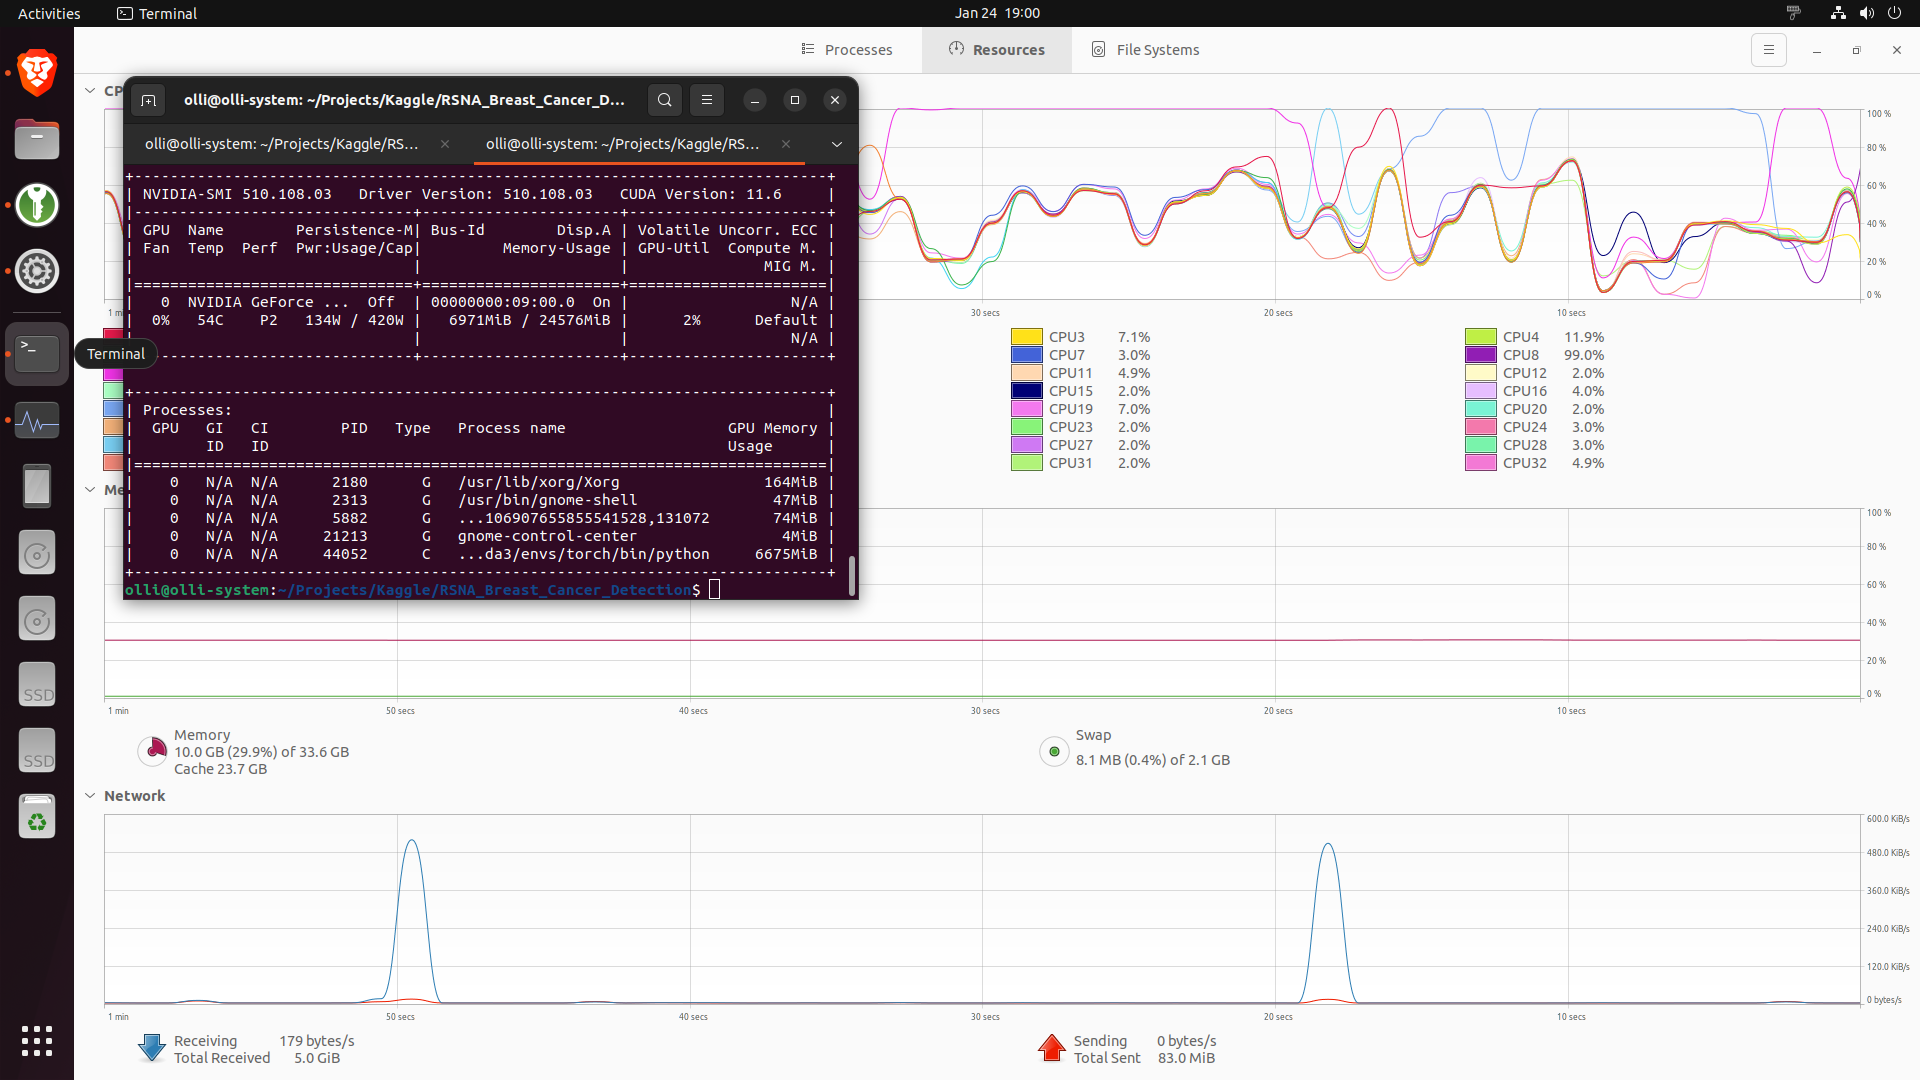

In [53]:
from IPython import display
gpu_pic = 'Pictures/GPU_Usage.png'
display.Image(gpu_pic)

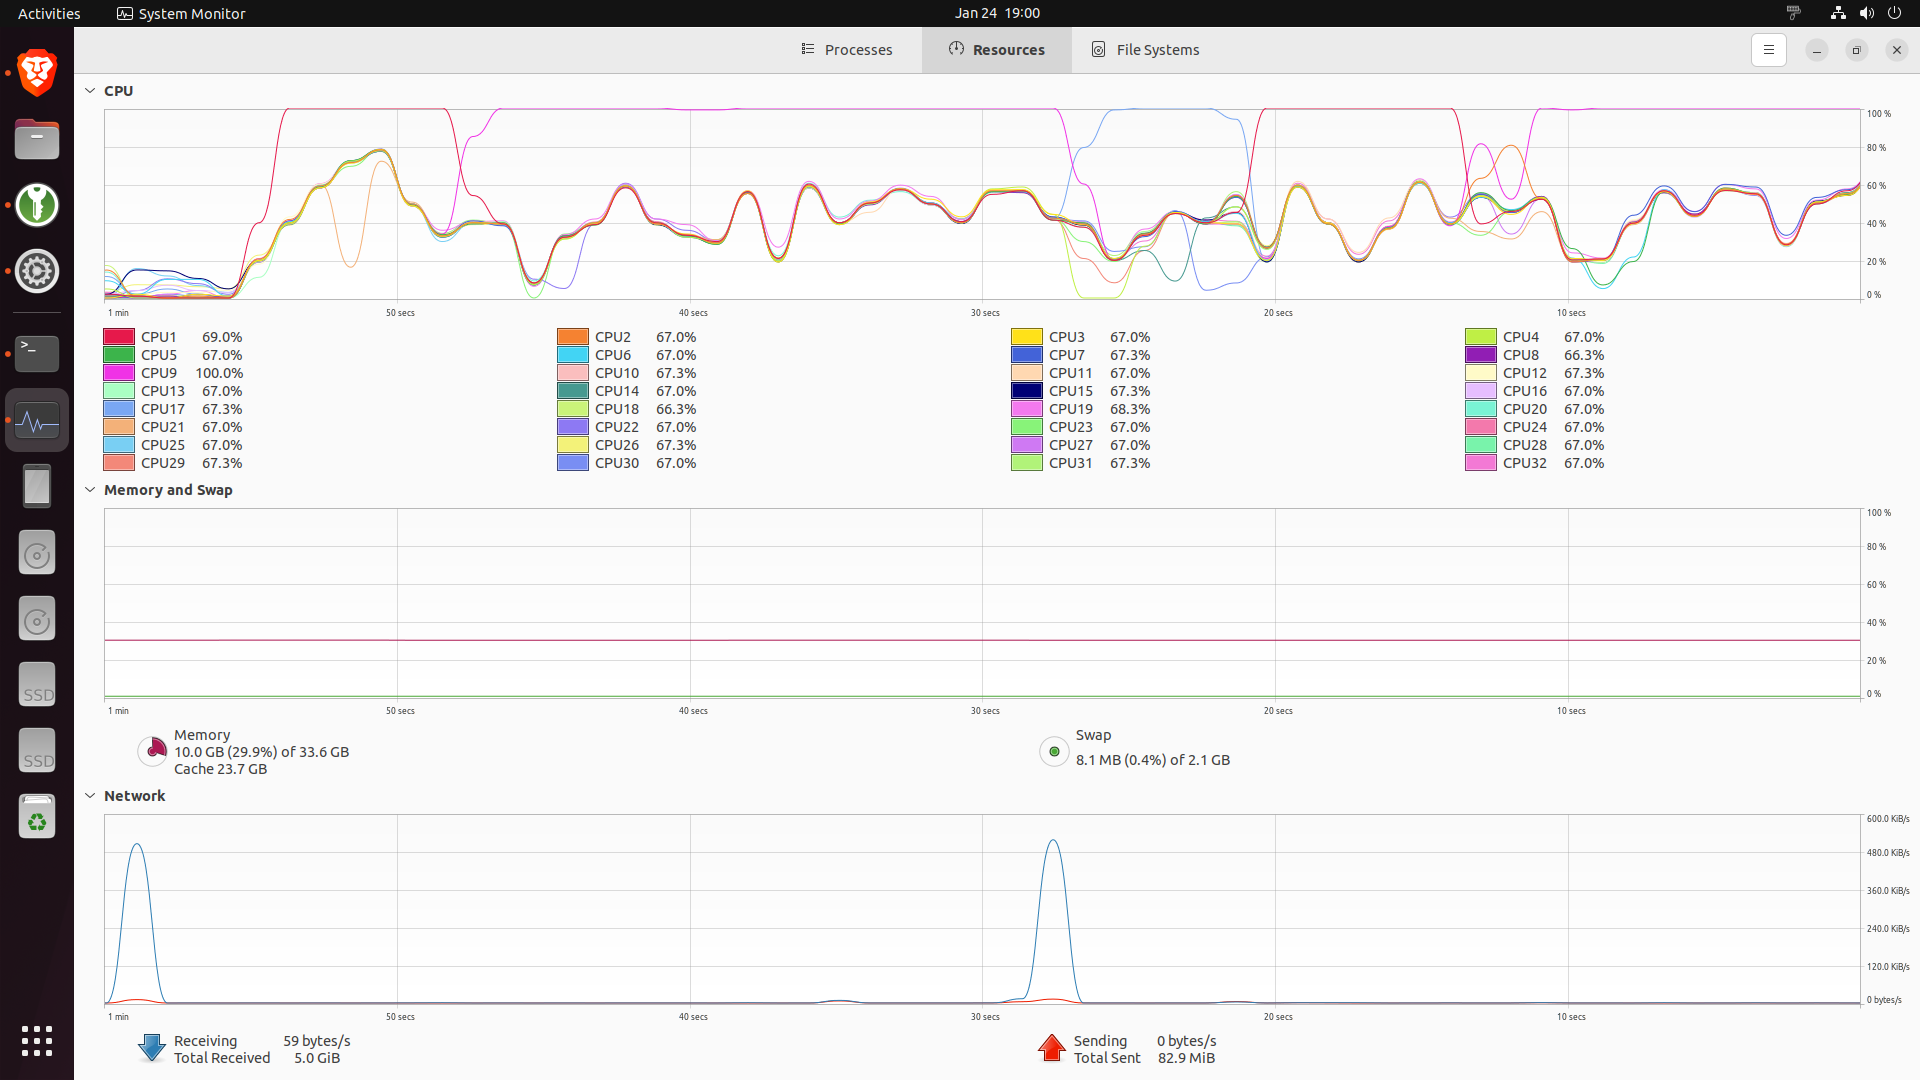

In [54]:
cpu_pic = 'Pictures/CPU_Usage.png'
display.Image(cpu_pic)